In [25]:
import os

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd

# Astropy
from astropy import units as u
from astropy.coordinates import SkyCoord

import healpy as hp

import fitsio as fits

from lsst.rsp import get_tap_service, retrieve_query

my_path =  '/sdf/data/rubin/user/kexcel/plots'

#from dustmaps.sfd import SFDQuery
#from dustmaps.config import config

This notebook was written for the Sprint Day at the 2025 DESC Meeting at UIUC. The goal was to plot the color-magnitude diagram to see if there's evidence of a RGB branch (Red Giant Branch - stellar feature) in the galaxy catalog. This is a very rough diagnostic for the state of star-galaxy separation in DP1 (based on i_SizeExtendedness). It was mostly intended to just get a start on data access.

In [2]:
service = get_tap_service("tap")
assert service is not None

In [3]:
#config['data_dir'] = 'sdf/data/rubin/user/kexcel/software'     # dustmaps
#dustmaps.sfd.fetch()
#sfd = SFDQuery()

First, query DP1 for objects in the Fornax field

In [4]:
R_g = 3.64
R_r = 2.70
R_i = 2.06

def query(service, ra, dec, radius=1.0, gmax=23.5):
    """ Return data queried from Rubin TAP

    Parameters
    ----------
    service: str
        TAP service
    ra: float
        Right Ascension [deg]
    dec: float
        Declination [deg]
    radius: float
        Radius around (ra, dec) [deg]

    Returns
    -------
    good_results: DataFrame
    """
\
    R_g = 3.64
    R_r = 2.70
    R_i = 2.06

    # Define our reference position on the sky and E(B-V) at that position using SFD reddening maps
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    #E_BV = sfd(coord)
    radius = radius * u.deg

    A_g = R_g #*E_BV
    A_r = R_r #*E_BV
    A_i = R_i #*E_BV
    
    # Quality selection and star--galaxy separation adapted from
    # https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb

    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    mag_threshold =26

    # assuming extendedness is the same in all bands we assume g_extendedness matches extendedness for dp0.2 tables
    
    safe_max_extended = 1.0
    
    query = f"""
        SELECT
            coord_ra AS ra, coord_dec AS dec,
            scisql_nanojanskyToAbMag(g_cModelFlux) AS mag_g,
            scisql_nanojanskyToAbMag(r_cModelFlux) AS mag_r,
            scisql_nanojanskyToAbMagSigma(g_cModelFlux, g_cModelFluxErr) AS magerr_g, 
            scisql_nanojanskyToAbMagSigma(r_cModelFlux, r_cModelFluxErr) AS magerr_r,
            scisql_nanojanskyToAbMag(g_cModelFlux) - {A_g} AS mag_corrected_g,
            scisql_nanojanskyToAbMag(r_cModelFlux) - {A_r} AS mag_corrected_r,
            i_sizeExtendedness, r_sizeExtendedness
        FROM dp1.Object
        WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND g_extendedness <= {str(safe_max_extended)}
        AND detect_isIsolated = 1
        AND deblend_failed = 0
        AND deblend_skipped = 0
    """
    
    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    async_results = job.fetch_result()
    results = async_results.to_table().to_pandas()
    job.delete()

    good_snr = (results['magerr_g'] < mag_err_threshold) & (results['magerr_r'] < mag_err_threshold)
    good_results = results[good_snr]
    
    return good_results



fornax = query(service, 40.00, -34.45, radius=1.0)

The giant hole in the Fornax data is because of failed deblending in the DP1 pipeline for this very crowded field

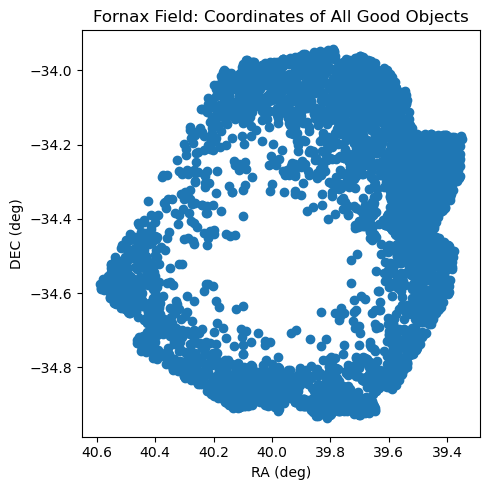

In [38]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.scatter(fornax['ra'], fornax['dec'])
ax.set(xlabel = 'RA (deg)', ylabel = 'DEC (deg)', title = 'Fornax Field: Coordinates of All Good Objects')
ax.invert_xaxis()
plt.tight_layout()
plt.savefig(my_path + '/fornax_objs.png')

In [5]:
#galaxies = fornax[(fornax['g_extendedness'] == 1.0) & (fornax['r_extendedness'] == 1.0)]
#stars = fornax[(fornax['g_extendedness'] == 0.0) & (fornax['r_extendedness'] == 0.0)]
galaxies = fornax[fornax['i_sizeExtendedness'] > 0.5]
stars = fornax[fornax['i_sizeExtendedness'] < 0.5]

In [6]:
fornax.columns

Index(['ra', 'dec', 'mag_g', 'mag_r', 'magerr_g', 'magerr_r',
       'mag_corrected_g', 'mag_corrected_r', 'i_sizeExtendedness',
       'r_sizeExtendedness'],
      dtype='object')

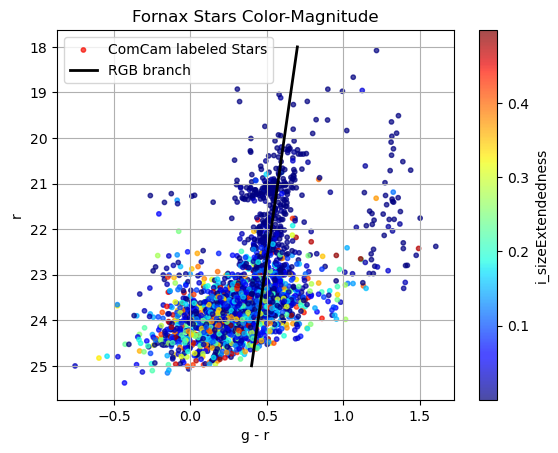

In [31]:
color_stars = stars['mag_g'] - stars['mag_r']
r_mag_stars = stars['mag_r']
plt.scatter(color_stars, r_mag_stars, s = 10, c = stars['i_sizeExtendedness'], alpha = 0.7, cmap = 'jet', label = 'ComCam labeled Stars')
plt.gca().invert_yaxis()
plt.xlabel('g - r')
plt.ylabel('r')
plt.title('Fornax Stars Color-Magnitude')
plt.plot(np.linspace(0.4,0.7, 10), np.linspace(25,18, 10), color = 'k', linewidth = 2, label = 'RGB branch')
plt.grid()
plt.legend()
plt.colorbar(label = 'i_sizeExtendedness')
plt.savefig(my_path + '/fornax_stars_colormag.png')

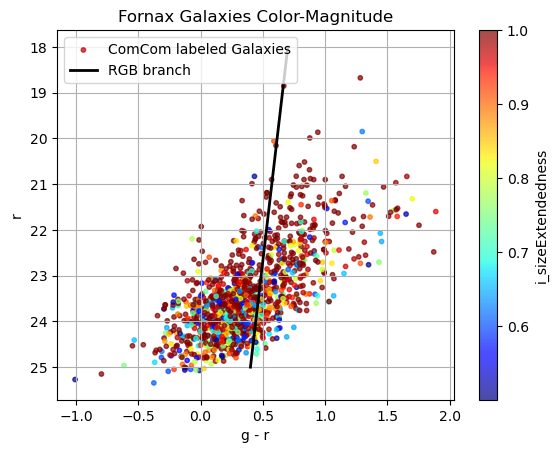

In [32]:
color_gal = galaxies['mag_g'] - galaxies['mag_r']
r_mag_gal = galaxies['mag_r']
plt.scatter(color_gal, r_mag_gal,  s = 10, c = galaxies['i_sizeExtendedness'], alpha = 0.7, cmap = 'jet', label = 'ComCom labeled Galaxies')
plt.gca().invert_yaxis()
plt.xlabel('g - r')
plt.ylabel('r')
plt.title('Fornax Galaxies Color-Magnitude')
plt.plot(np.linspace(0.4,0.7, 10), np.linspace(25,18, 10), color = 'k', linewidth = 2, label = 'RGB branch')
plt.grid()
plt.legend()
plt.colorbar(label = 'i_sizeExtendedness')
plt.savefig(my_path + '/fornax_gals_colormag.png')